In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sns

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [17]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-3.528878,0.067576,0.932560,25.2,108.666275
1,1,-4.131134,0.071671,1.029626,26.9,109.853065
2,2,-3.964852,0.073103,1.023653,27.9,112.921150
3,3,-3.710638,0.079740,0.989072,28.6,112.257874
4,4,-3.307759,0.077855,0.967257,25.3,112.399788


<Axes: >

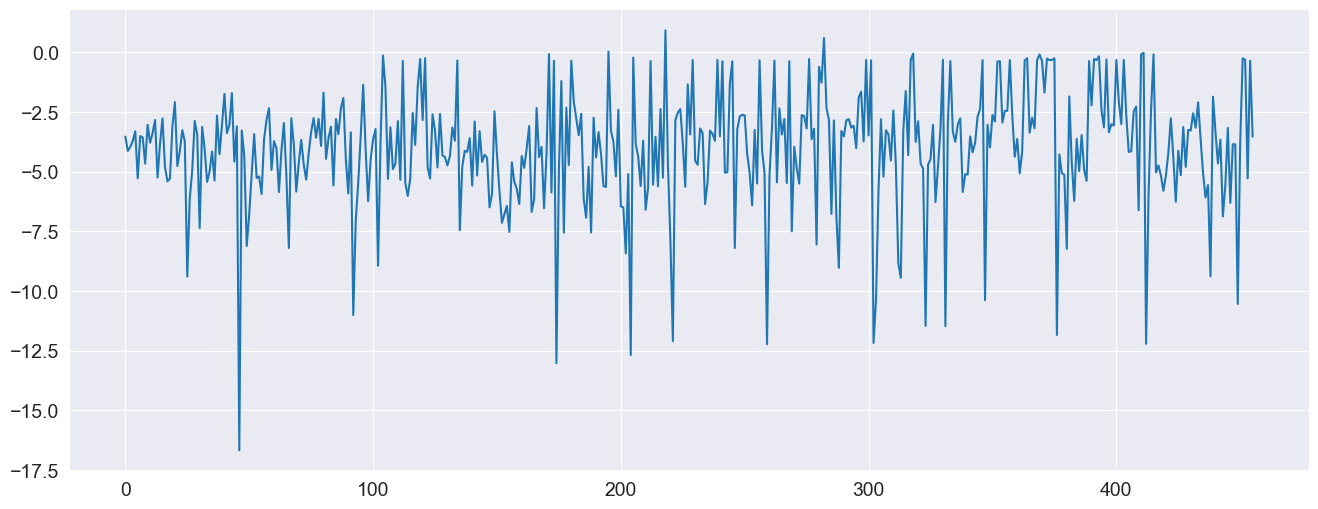

In [18]:
data15.Delta.plot()

<Axes: >

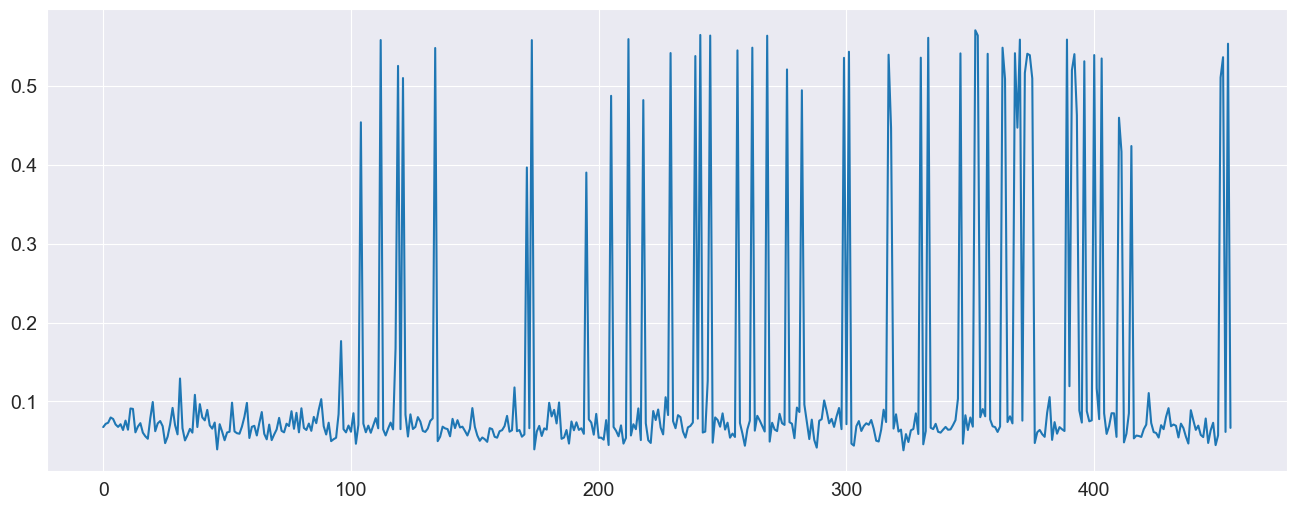

In [19]:
data15.Damkohler.plot()

<Axes: >

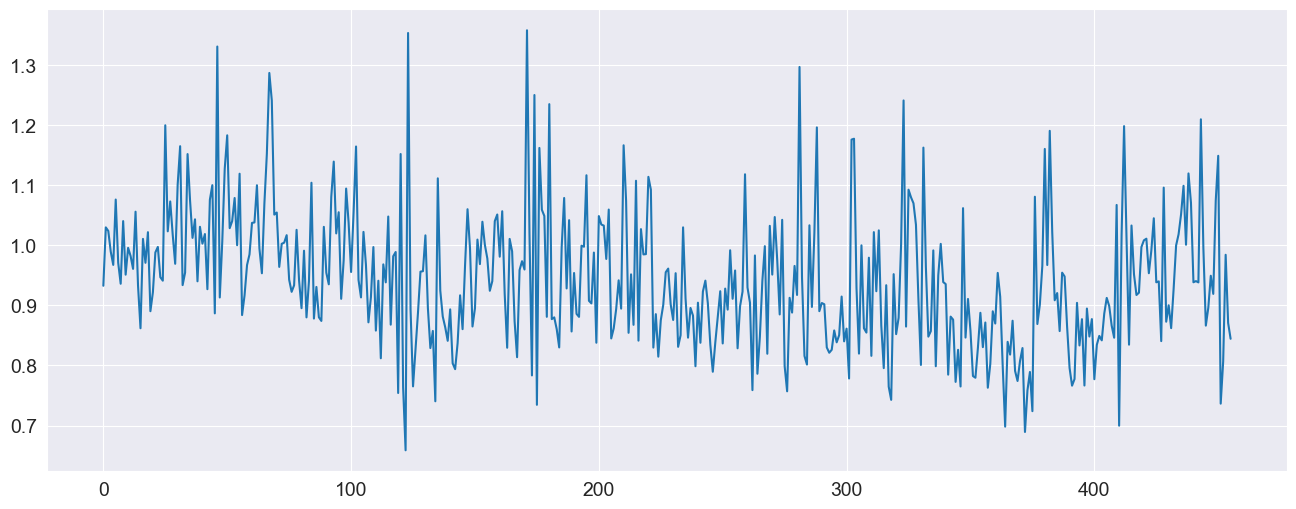

In [20]:
data15.Sigma.plot()

In [21]:
data15 = data15.drop(['Damkohler', 'CUM_Steam'], axis=1)

In [22]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [23]:
data15.head()

,Delta,Sigma,Woodloading
Time,,,
2023-01-01 00:00:00,-3.528878,0.932560,108.666275
2023-01-01 00:01:00,-4.131134,1.029626,109.853065
2023-01-01 00:02:00,-3.964852,1.023653,112.921150
2023-01-01 00:03:00,-3.710638,0.989072,112.257874
2023-01-01 00:04:00,-3.307759,0.967257,112.399788


In [24]:
data15_train = data15[:410]
data15_test = data15[410:]

In [25]:
data15_train.tail()

,Delta,Sigma,Woodloading
Time,,,
2023-01-01 06:45:00,-4.172553,0.912359,95.201584
2023-01-01 06:46:00,-4.151294,0.898867,95.179120
2023-01-01 06:47:00,-2.476329,0.866141,95.548090
2023-01-01 06:48:00,-2.273118,0.846193,95.176450
2023-01-01 06:49:00,-6.614378,1.066931,95.168365


In [27]:
data15_test.head

<bound method NDFrame.head of                          Delta     Sigma  Woodloading
Time                                                 
2023-01-01 06:50:00  -0.089431  0.699894    95.179190
2023-01-01 06:51:00  -0.021616  1.017201    93.540530
2023-01-01 06:52:00 -12.215373  1.197968    96.737830
2023-01-01 06:53:00  -5.959367  1.009257    97.097946
2023-01-01 06:54:00  -2.450689  0.834601   119.443611
2023-01-01 06:55:00  -0.086816  1.032725   119.783524
2023-01-01 06:56:00  -5.034012  0.951711   113.750542
2023-01-01 06:57:00  -4.739834  0.917188   115.094070
2023-01-01 06:58:00  -5.168605  0.921050   115.286476
2023-01-01 06:59:00  -5.803137  0.996934   115.359390
2023-01-01 07:00:00  -5.162786  1.008084   100.718018
2023-01-01 07:01:00  -4.206190  1.010822   105.056221
2023-01-01 07:02:00  -2.762567  0.953408   102.277687
2023-01-01 07:03:00  -4.409840  0.990977    98.708435
2023-01-01 07:04:00  -6.259200  1.044776   106.690132
2023-01-01 07:05:00  -4.123903  0.938327   102.89261

### Stationarity

In [28]:
# Sigma Stationarity
sts.adfuller(data15_comp.Sigma)

(-4.754768668934511,
 6.632288893693148e-05,
 6,
 449,
 {'1%': -3.4449982835447894,
  '5%': -2.8679986379826814,
  '10%': -2.5702102140862397},
 -699.4494343779893)

### ACF

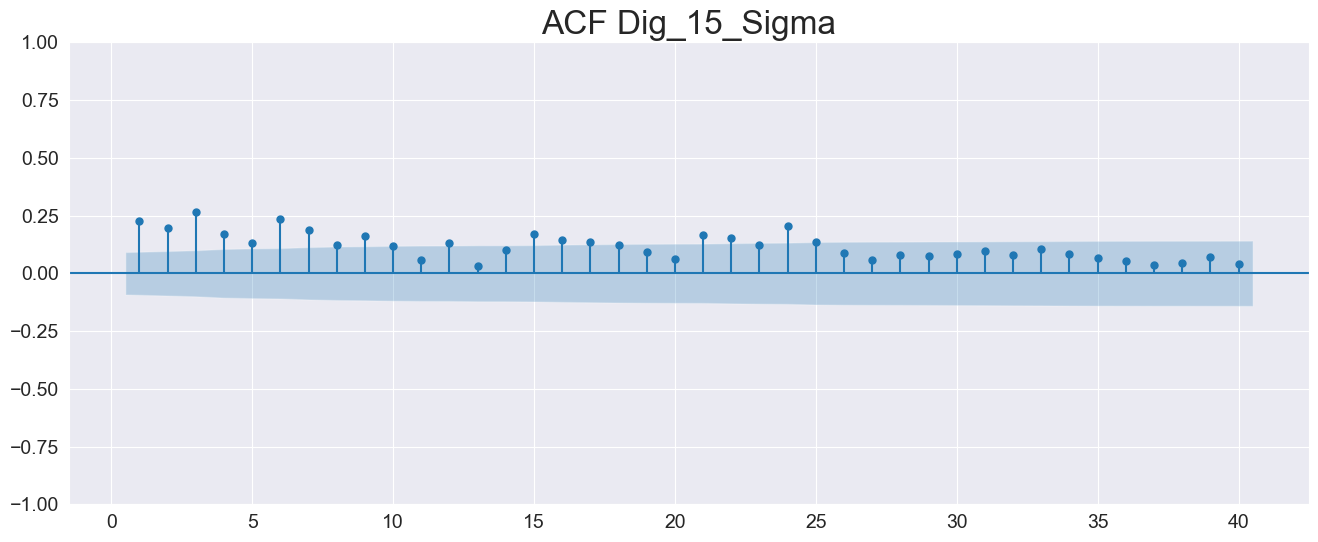

In [29]:
# Delta ACF
sgt.plot_acf(data15.Sigma, lags = 40, zero = False)
plt.title("ACF Dig_15_Sigma", size = 24)
plt.show()

### PACF

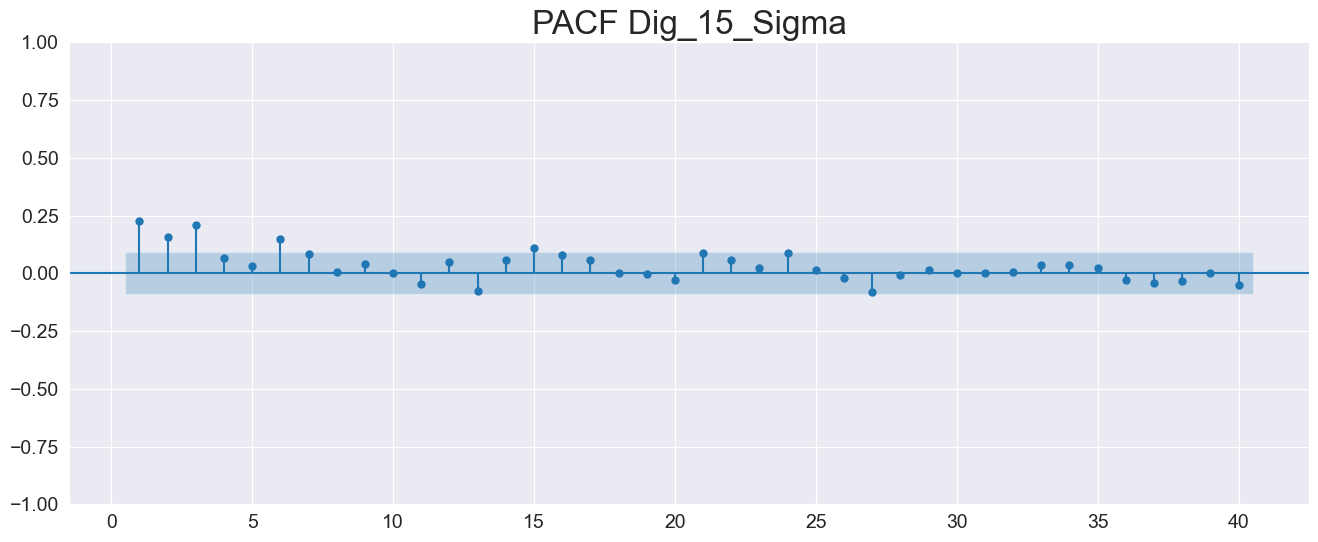

In [30]:
# Sigma PACF
sgt.plot_pacf(data15.Sigma, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_Sigma", size = 24)
plt.show()

In [31]:
model_auto = auto_arima(data15_train.Sigma)
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  410
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 336.389
Date:                Mon, 01 Apr 2024   AIC                           -668.779
Time:                        02:22:01   BIC                           -660.751
Sample:                    01-01-2023   HQIC                          -665.602
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9130      0.020    -46.312      0.000      -0.952      -0.874
sigma2         0.0113      0.001     18.606      0.000       0.010       0.012
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               101.53
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.90
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
# Model
model_params = ARIMA(data15_train.Sigma, order=(0, 1, 1))
results_arima = model_params.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sigma   No. Observations:                  410
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 336.389
Date:                Mon, 01 Apr 2024   AIC                           -668.779
Time:                        02:22:31   BIC                           -660.751
Sample:                    01-01-2023   HQIC                          -665.602
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9130      0.020    -46.312      0.000      -0.952      -0.874
sigma2         0.0113      0.001     18.606      0.000       0.010       0.012
Ljung-Box (L1) (Q):                   0.49   Jarque-

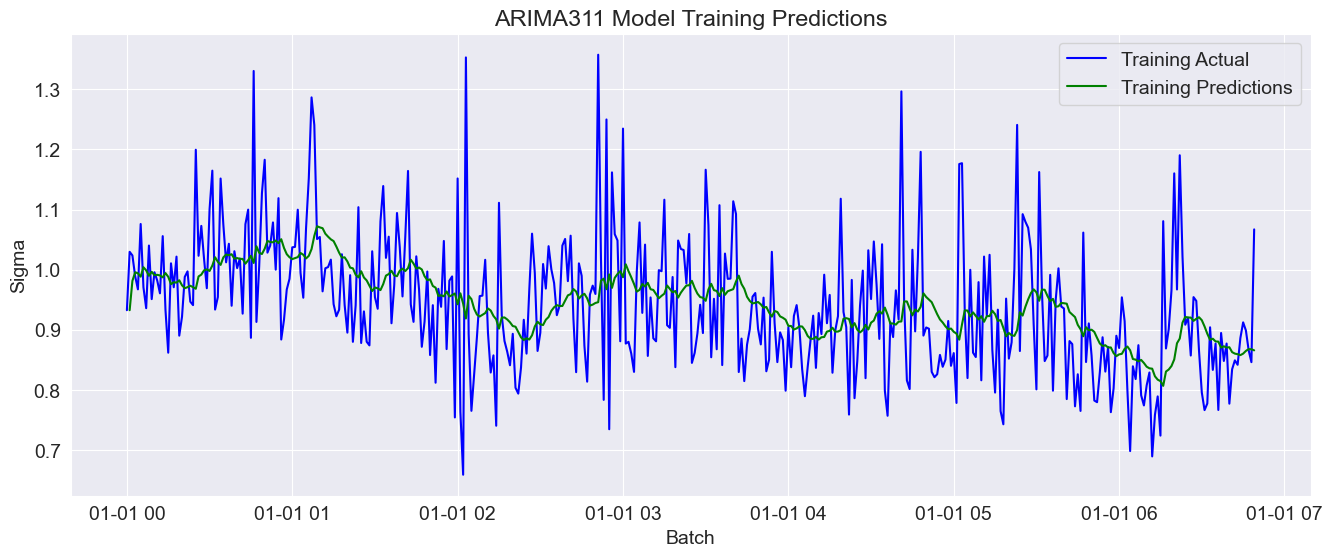

In [33]:
start_date = '2023-01-01 06:50:00'
end_date = '2023-01-01 07:35:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima.predict())
# print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['Sigma'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA311 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Sigma')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [34]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['Sigma'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['Sigma'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 0.11559544527373747
mae 0.08297508520868456


### Test Plots

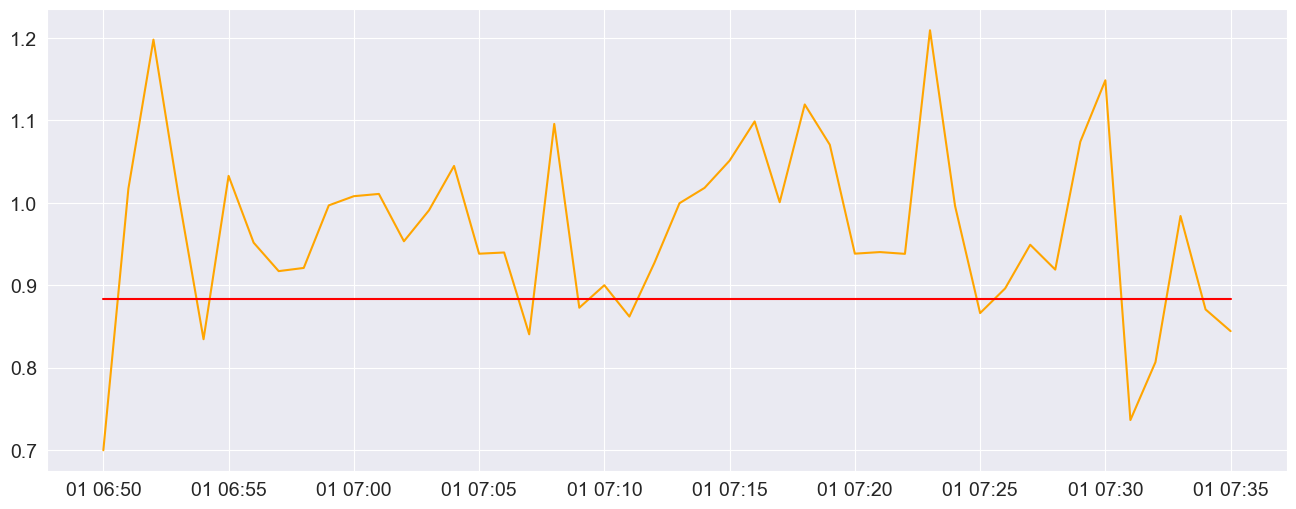

In [35]:
# Plot test data
plt.plot(data15_test.index, data15_test['Sigma'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### Test Performance

In [36]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['Sigma'], test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['Sigma'], test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 0.13457075109655928
mae 0.10880308893020915
